https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

In [1]:
import keras
print("finished importing")
from matplotlib import pyplot as plt
import numpy as np
import gzip
print("gzip load")
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

finished importing
gzip load


Using TensorFlow backend.


In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28, 28)
        return data
    
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

        

In [3]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels
    
train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)


In [4]:
print ("Training set (images) shape: {shape}".format(shape=train_data.shape))
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [5]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

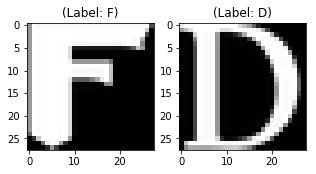

In [6]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28, 28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in test data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28, 28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")



In [7]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [9]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,                                                                test_size=0.2,
                                                               random_state=13)

In [10]:
batch_size = 128
epochs = 10
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))


In [11]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [12]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [13]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

In [14]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 162s 3ms/step - loss: 0.0342 - val_loss: 0.0135
Epoch 2/10
48000/48000 [==============================] - 165s 3ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 3/10
48000/48000 [==============================] - 165s 3ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/10
48000/48000 [==============================] - 164s 3ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/10
48000/48000 [==============================] - 164s 3ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/10
48000/48000 [==============================] - 164s 3ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 7/10
48000/48000 [==============================] - 163s 3ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 8/10
48000/48000 [==============================] - 165s 3ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 9/10
48000/48000 [==============================] - 165s 3ms/step - loss: 0.0033 - val_loss: 0.0

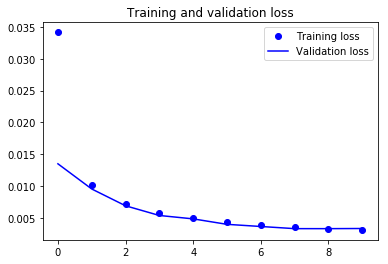

In [15]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [16]:
pred = autoencoder.predict(test_data)
pred.shape

(10000, 28, 28, 1)

In [22]:
Arr = test_data[0, ...]
Arr.shape

(28, 28, 1)

Test images


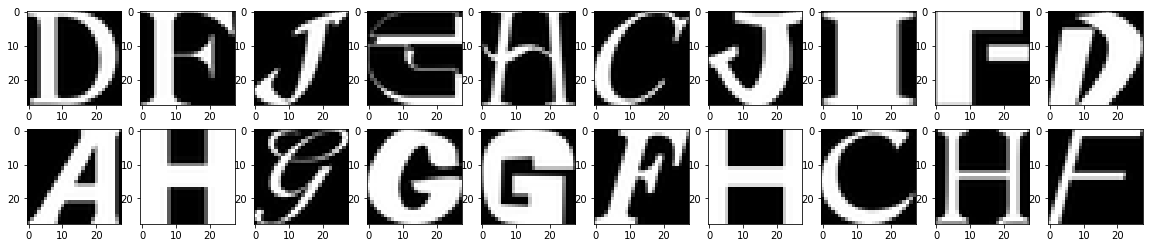

In [19]:
plt.figure(figsize=(20,4))
print("Test images")
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
plt.show()

In [23]:
# Add noise [0-0.5], normal gaussian distribution matrix
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size = valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc = 0.0, scale=1.0, size=test_data.shape)

# Clamp values
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

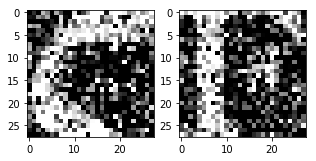

In [24]:
plt.figure(figsize=[5,5])

#Display first image in training and testing data with noise
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28, 28))
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img=np.reshape(x_test_noisy[1], (28, 28))
plt.imshow(curr_img, cmap='gray')


In [32]:
# Denoising network

#Encoder - 32-3x3 filters, 64-3x3 filters, 128-3x3 filters
#Decoder 128 - 64 - 1 -3x3

batch_size = 128
epochs = 5
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x,y, inChannel))

def autoencoderModelBuild(input_img):
    # encoder
    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    
    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

autoencoder = Model(input_img, autoencoderModelBuild(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer=RMSprop())

In [33]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))


Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 187s 4ms/step - loss: 0.0504 - val_loss: 0.0280
Epoch 2/5
48000/48000 [==============================] - 184s 4ms/step - loss: 0.0240 - val_loss: 0.0222
Epoch 3/5
48000/48000 [==============================] - 182s 4ms/step - loss: 0.0206 - val_loss: 0.0183
Epoch 4/5
48000/48000 [==============================] - 201s 4ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 5/5
48000/48000 [==============================] - 166s 3ms/step - loss: 0.0179 - val_loss: 0.0170


AttributeError: module 'matplotlib.pyplot' has no attribute 'legent'

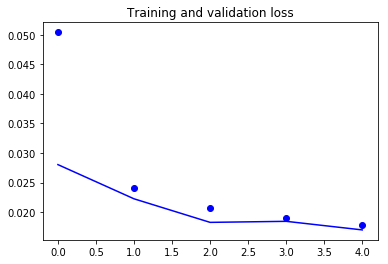

In [34]:
# Plot the loss values 
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legent()
plt.show()


Test Images


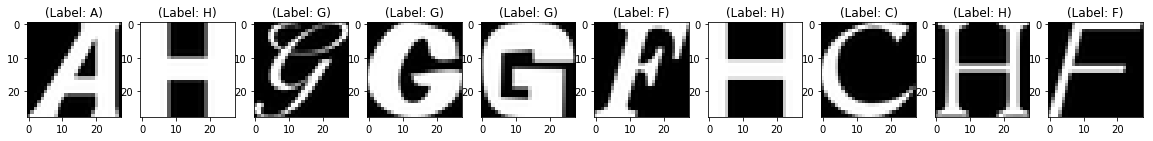

Test Images with Noise


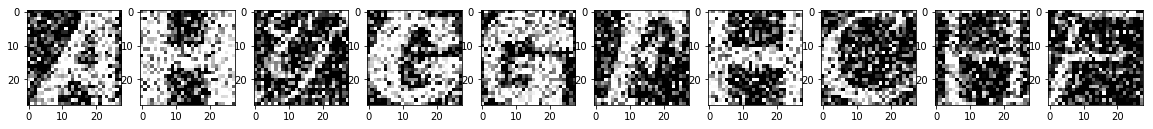

Reconstruction of Noisy Test Images


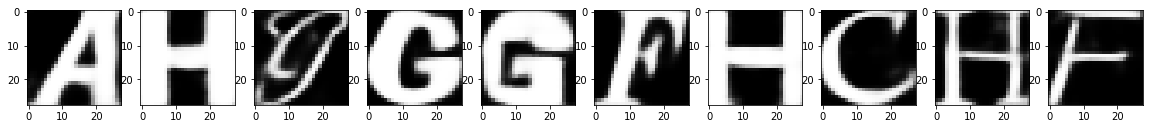

In [35]:
# Predict on the test data set
pred = autoencoder.predict(x_test_noisy)

# Show original test images, test images with noise and reconstruction
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10, 20, 1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()